Model: XGBoost
Transformer: ESM2_650M
Dataset: allergen_data

Loading ESM2 model and XGBoost model...

Loading dataset...

Embedding and predicting 1000 sequences...
100%|##########| 1000/1000 [23:57<00:00,  1.44s/it]

Classification Report:
/opt/miniconda3/envs/allergen_app_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/envs/allergen_app_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/envs/allergen_app_env/lib/python3.9/site-packages/sklear

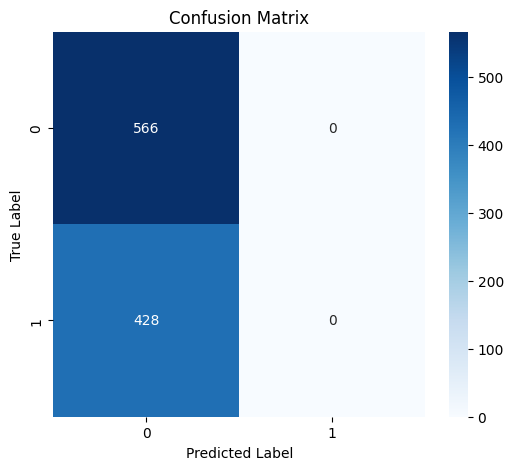


✅ All logs saved to: logs/XGBoost_ESM2_650M_allergen_data_batch_test_log.txt


In [8]:
# ==========================================
# 🧬 Test Allergenicity Predictor (Batch Testing Notebook with Logging)
# ==========================================

# 1. IMPORTS
import pandas as pd
import numpy as np
import torch
import joblib
import os
import sys
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from contextlib import redirect_stdout, redirect_stderr

from esm import pretrained

# 2. SETUP LOGGING
model_name = "XGBoost"
transformer_name = "ESM2_650M"
dataset_name = "allergen_data"

log_filename = f"{model_name}_{transformer_name}_{dataset_name}_batch_test_log.txt"
log_path = os.path.join("logs", log_filename)
os.makedirs("logs", exist_ok=True)

class Tee:
    def __init__(self, *streams):
        self.streams = streams

    def write(self, text):
        for stream in self.streams:
            stream.write(text)
            stream.flush()

    def flush(self):
        for stream in self.streams:
            stream.flush()

# 3. DEFINE FUNCTIONS
def load_esm2_model():
    model, alphabet = pretrained.esm2_t33_650M_UR50D()
    model.eval()
    batch_converter = alphabet.get_batch_converter()
    return model, batch_converter

def load_xgb_model(path):
    return joblib.load(path)

def sequence_to_embedding(seq, esm_model, batch_converter):
    valid = set("ACDEFGHIKLMNPQRSTVWY")
    seq = ''.join(filter(str.isalpha, seq.strip().upper()))
    if not seq:
        return None
    if any(aa not in valid for aa in seq):
        return None
    if not (5 <= len(seq) <= 2000):
        return None
    batch = [("protein", seq)]
    _, _, tokens = batch_converter(batch)
    with torch.no_grad():
        out = esm_model(tokens, repr_layers=[33], return_contacts=False)
    emb = out["representations"][33][0, 0, :].cpu().numpy().reshape(1, -1)
    return emb

# 4. MAIN SCRIPT
with open(log_path, "w") as log_file:
    tee = Tee(sys.stdout, log_file)
    with redirect_stdout(tee), redirect_stderr(tee):

        print(f"Model: {model_name}")
        print(f"Transformer: {transformer_name}")
        print(f"Dataset: {dataset_name}\n")

        # Load models
        print("Loading ESM2 model and XGBoost model...")
        esm_model, batch_converter = load_esm2_model()
        xgb_model = load_xgb_model("../XGBoost_ESM-2_1280dim_algpred2_xgboost_model.pkl")

        # Load data
        print("\nLoading dataset...")
        data = pd.read_csv("allergen_data_with_full_sequences.csv")
        sequences = data["full_parent_protein_sequence"]
        true_labels = data["label"]

        # Set number of datapoints
        N = 1000  # <-- Change this number as needed
        if N > len(sequences):
            print(f"Warning: Requested {N} datapoints, but dataset only has {len(sequences)}.")
            N = len(sequences)

        sequences = sequences.iloc[:N]
        true_labels = true_labels.iloc[:N]

        # Embed and predict
        print(f"\nEmbedding and predicting {N} sequences...")
        predictions = []
        valid_indices = []

        for idx, seq in tqdm(enumerate(sequences), total=len(sequences)):
            emb = sequence_to_embedding(seq, esm_model, batch_converter)
            if emb is not None:
                prob = xgb_model.predict_proba(emb)[0, 1]
                pred = xgb_model.predict(emb)[0]
                predictions.append(pred)
                valid_indices.append(idx)
            else:
                predictions.append(None)

        # Filter valid
        filtered_true = true_labels.iloc[valid_indices].reset_index(drop=True)
        filtered_preds = [pred for pred in predictions if pred is not None]

        # Evaluate
        print("\nClassification Report:")
        print(classification_report(filtered_true, filtered_preds))

        cm = confusion_matrix(filtered_true, filtered_preds)
        print("\nConfusion Matrix:")
        print(cm)

# 5. PLOT CONFUSION MATRIX (outside logging so plot displays nicely)
cm = confusion_matrix(filtered_true, filtered_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

print(f"\n✅ All logs saved to: {log_path}")


In [6]:
data = pd.read_csv("../algpred2_test.csv")
data

,id,sequence,label
0,P_7275,MKNYLSFGMFALLFALTFGTVNSVQAIAGPEWLLDRPSVNNSQLVV...,1
1,P_7276,MAGPEWLLDRPSVNNSQLVVSVAGTVEGTNQDISLKFFEIDLTSRP...,1
2,P_9753,MHYSLFFGAALAASVSTVSAEAGCNNDGGNWYCSAVDLITYSGFST...,1
3,P_269,HIPSLEKPLQQQPLPLQQILWYQQQQPIQQQPQPFPQQPPCSQQQQ...,1
4,P_270,HIPSLEKPSQQQPLPLQQILWYHQQQPIQQQPQPFPQQPPCSQQQQ...,1
...,...,...,...
4025,N_281591,MAFNGYGIFDSDPRKNPSSDLRTQFWLAFLLGASACVFFCFFRKRW...,0
4026,N_240722,MDESRRQRPAGHVAANLSPQGARQRSFKDWLASYVHSNPHGASGRP...,0
4027,N_39127,MKRVKSESFRGVYSSRRFKLSHFLLAIAGFYLVFLAFKFPHFIEMV...,0
4028,N_144660,MEVKERRPYRSLTSRRDTERRYTSSSADSEDGKINPKSYSSSETLK...,0
